[Ссылка на контест Kaggle](https://www.kaggle.com/competitions/critical-temperature-of-superconductors/)

Данные о сверхпроводниках взяты из базы данных сверхпроводящих материалов, собранной Национальным институтом материаловедения Японии NIMS.

Для каждого сверхпроводника в данных приведены полная химическая формула сверхпроводника, а также 8 основных химических свойств (абсолютное значение, среднее, взвешенное среднее и так далее): атомная масса, энергия ионизации, радиус атома, плотность, удельная теплота плавления, энергия сродства к электрону, теплопроводность, валентность.


# Connections

In [ ]:
data_root = "/content/drive/MyDrive/Colab Notebooks/data/CriticalTemperatureSuperconductors/"

def full_data_path(filename):
  return data_root + filename

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV

from tqdm import tqdm

# Data load

In [ ]:
train = pd.read_csv(full_data_path("train.csv"))
formula_train = pd.read_csv(full_data_path("formula_train.csv"))

print(f"Train dataset shape: {train.shape}")
print(f"Train_formula dataset shape: {formula_train.shape}")

train.head()

Train dataset shape: (17010, 82)
Train_formula dataset shape: (17010, 88)


,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


In [ ]:
formula_train.head()

,H,He,Li,Be,B,C,N,O,F,Ne,...,Au,Hg,Tl,Pb,Bi,Po,At,Rn,critical_temp,material
0,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,29.0,Ba0.2La1.8Cu1O4
1,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,26.0,Ba0.1La1.9Ag0.1Cu0.9O4
2,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,19.0,Ba0.1La1.9Cu1O4
3,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,22.0,Ba0.15La1.85Cu1O4
4,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,23.0,Ba0.3La1.7Cu1O4


In [ ]:
test = pd.read_csv(full_data_path("test.csv"))
formula_test = pd.read_csv(full_data_path("formula_test.csv"))

print(f"Test dataset shape: {test.shape}")
print(f"Test_formula dataset shape: {formula_test.shape}")

Test dataset shape: (4253, 81)
Test_formula dataset shape: (4253, 87)


# Data preprocessing

In [ ]:
print("Number of missing values in train datasets:")
print(train.isna().sum().sum())
print(formula_train.isna().sum().sum())

Number of missing values in train datasets:
0
0


In [ ]:
print("Number of missing values in test datasets:")
print(test.isna().sum().sum())
print(formula_test.isna().sum().sum())

Number of missing values in test datasets:
0
0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17010 entries, 0 to 17009
Data columns (total 82 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   number_of_elements               17010 non-null  int64  
 1   mean_atomic_mass                 17010 non-null  float64
 2   wtd_mean_atomic_mass             17010 non-null  float64
 3   gmean_atomic_mass                17010 non-null  float64
 4   wtd_gmean_atomic_mass            17010 non-null  float64
 5   entropy_atomic_mass              17010 non-null  float64
 6   wtd_entropy_atomic_mass          17010 non-null  float64
 7   range_atomic_mass                17010 non-null  float64
 8   wtd_range_atomic_mass            17010 non-null  float64
 9   std_atomic_mass                  17010 non-null  float64
 10  wtd_std_atomic_mass              17010 non-null  float64
 11  mean_fie                         17010 non-null  float64
 12  wtd_mean_fie      

В данной задаче у нас имеются два датасета для тренировки и для теста, для удобства сформируем один DataFrame.

Так как колонка с целевой переменной имеется в обоих датасетах, удалим её из одного, чтобы не дублировать.

In [ ]:
formula_train = formula_train.drop(columns=['critical_temp'])

train_full = pd.concat([train, formula_train], axis=1)

print(f"Full Train dataset shape: {train_full.shape}")

Full Train dataset shape: (17010, 169)


In [ ]:
# Удалим из данных ненужную колонку 'material'
train_full.drop(columns=['material'], inplace=True)

In [ ]:
train_full.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,Ir,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0


In [ ]:
X = train_full.drop(columns=['critical_temp'])
y = train_full['critical_temp']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (17010, 167)
Target shape: (17010,)


In [ ]:
test_full = pd.concat([test, formula_test], axis=1)

print(f"Full Test dataset shape: {test_full.shape}")

Full Test dataset shape: (4253, 168)


Удалим из данных ненужную колонку 'material', так как мы добавили данные о поэлементном составе

In [ ]:
test_full.drop(columns=['material'], inplace=True)

# Learning

## cross validation

In [ ]:
num_folds = 5
seed = 42

kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

model = LinearRegression()
scores = cross_val_score(model, X, y, cv=kfold, scoring='r2')

print(scores)
print(scores.mean())

[ 0.7538253   0.74826435 -0.71675976  0.76756534  0.19915868]
0.3504107834912407


In [ ]:
predictions = np.zeros(len(y))
r2_scores = []

for train_index, val_index in kfold.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    predictions[val_index] = y_pred

    # Оцениваем и сохраняем метрику качества (MSE)
    r2 = r2_score(y_val, y_pred)
    r2_scores.append(r2)

# Среднее значение ошибки
print("R2 на каждом разбиении:", r2_scores)
print("Средний R2:", np.mean(r2_scores))


R2 на каждом разбиении: [0.7538253028800657, 0.7482643547035956, -0.7167597628351638, 0.7675653442073693, 0.19915867850033686]
Средний R2: 0.3504107834912407


при кросс-валидации мы получаем очень нестабильные scores, лучший из которых почти не отличается от score при train-test split, так что далее будем использовать простое разделение

## train-test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(f'Train dataset size: {X_train.shape}, {y_train.shape}')
print(f'Train dataset size: {X_test.shape}, {y_test.shape}')

Train dataset size: (13608, 167), (13608,)
Train dataset size: (3402, 167), (3402,)


In [ ]:
models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    XGBRegressor()
    ]
predictions = []

In [ ]:
for model in tqdm(models):
  model.fit(X_train, y_train)
  predict = model.predict(X_test)
  predictions.append(predict)

100%|██████████| 5/5 [02:58<00:00, 35.72s/it]


In [ ]:
for model, y_pred in zip(models, predictions):
  print('Model:', model)
  print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
  print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
  print('R2 score:', r2_score(y_test, y_pred))
  print('-----------------------------------')

Model: LinearRegression()
Mean Absolute Error: 13.012634492365347
Mean Squared Error: 967.086141929516
R2 score: 0.17967189991874144
-----------------------------------
Model: DecisionTreeRegressor()
Mean Absolute Error: 2.2231355370242762
Mean Squared Error: 41.535479259194474
R2 score: 0.964767646531799
-----------------------------------
Model: RandomForestRegressor()
Mean Absolute Error: 3.1583923913847536
Mean Squared Error: 38.54012454371245
R2 score: 0.967308447745141
-----------------------------------
Model: GradientBoostingRegressor()
Mean Absolute Error: 8.106983761632959
Mean Squared Error: 146.61922266212565
R2 score: 0.8756306567253255
-----------------------------------
Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, 

Лучший score показала модель RandomForestRegressor, но мы возьмём DecisionTreeRegressor, так как результат почти тот же, но DecisionTreeRegressor обучается очень быстро по сравнению с RandomForestRegressor.



In [ ]:
best_model = DecisionTreeRegressor(random_state=52)

In [ ]:
param_grid = {
    'splitter': ['best', 'random'],
    'max_depth': [5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8]
}

In [ ]:
grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X, y)

print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", -grid_search.best_score_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found: {'max_depth': 30, 'min_samples_leaf': 8, 'min_samples_split': 2, 'splitter': 'random'}
Best cross-validation score: -0.6454050849407686


Best parameters found: {'max_depth': 30, 'min_samples_leaf': 8, 'min_samples_split': 2, 'splitter': 'random'}

In [ ]:
final_model = DecisionTreeRegressor(
    max_depth=30,
    min_samples_leaf=8,
    min_samples_split=2,
    splitter='random',
    random_state=52)

final_model.fit(X, y)

DecisionTreeRegressor(max_depth=30, min_samples_leaf=8, random_state=52,
                      splitter='random')

# Predict to submit

In [ ]:
y_pred = final_model.predict(test_full)

In [ ]:
y_pred = pd.DataFrame(y_pred, columns=['critical_temp'])
y_pred = y_pred.reset_index()
print("Shape of submit df:", y_pred.shape)
y_pred.head()

Shape of submit df: (4253, 2)


,index,critical_temp
0,0,28.283333
1,1,26.660000
2,2,83.623590
3,3,83.271538
4,4,89.525000


In [ ]:
y_pred.to_csv("submit.csv", index=False)

My score:

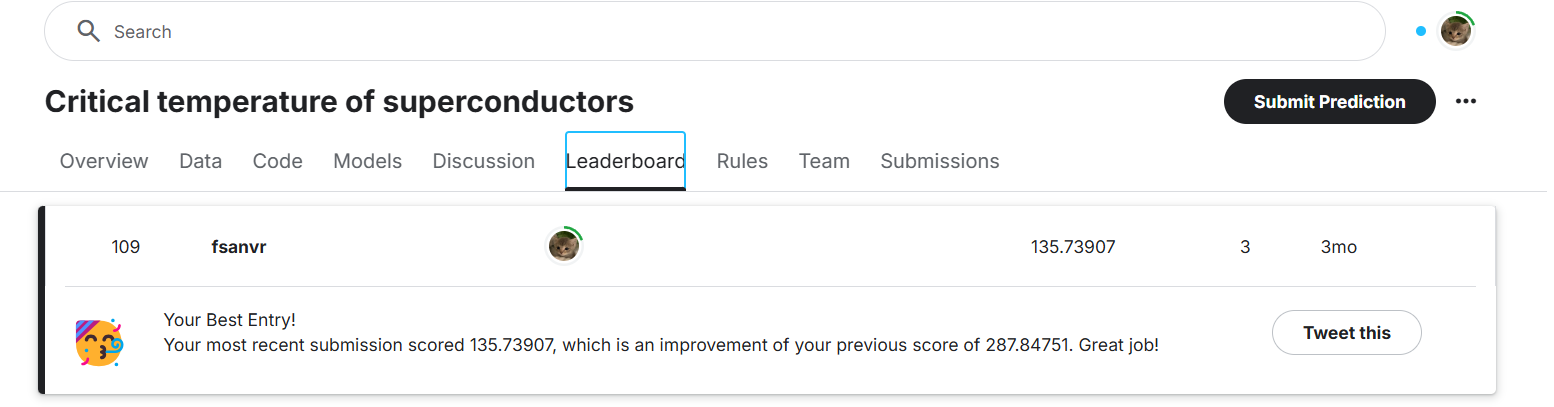